In [1]:
import comptools as comp
import comptools.analysis.plotting as plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
import multiprocessing as mp
import os

%matplotlib inline

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)
/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Detector livetime calculation

For a reference see the [IT-73 spectrum livetime reference](https://wiki.icecube.wisc.edu/index.php/IceTop-73_Spectrum_Analysis#Live-time_calculation).

In [2]:
config = 'IC86.2012'

In [3]:
time_bins = np.linspace(0, 2, 101)
time_midpoints = (time_bins[1:] + time_bins[:-1]) / 2
time_mask = time_midpoints < 1.4

In [4]:
def livetime_fit_func(t, I0, T):
    return I0 * np.exp(-t/T)

In [5]:
def get_livetime_counts_and_fit(month=None):
    # Get time difference histogram counts from level3 pickle files
    counts = comp.datafunctions.get_level3_livetime_hist(config, month)
    # Fit decaying exponential to histogram
    popt, pcov = curve_fit(livetime_fit_func, time_midpoints[time_mask], counts[time_mask],
                           sigma=np.sqrt(counts[time_mask]), p0=[1e5, 1e-2])
    I0_fit, T_fit = popt
    I0_fit_err, T_fit_err = np.sqrt(np.diag(pcov))
    # Get livetime from fit parameters
    livetime = T_fit * np.sum(counts)
    livetime_err = T_fit_err * np.sum(counts)

    data_dict = {'month': month, 'counts': counts,
                 'livetime': livetime, 'livetime_err': livetime_err,
                 'I0_fit': I0_fit, 'I0_fit_err': I0_fit_err,
                 'T_fit': T_fit, 'T_fit_err': T_fit_err}
    
    month_str = datetime.date(2000, month, 1).strftime('%B')
    print('Completed month {}'.format(month_str))
    
    return data_dict

In [6]:
pool = mp.Pool(processes=12)
results = [pool.apply_async(get_livetime_counts_and_fit, args=(month,)) for month in range(1, 13)]
output = [p.get() for p in results]

Completed month May
Completed month June
Completed month July
Completed month February
Completed month September
Completed month April
Completed month August
Completed month November
Completed month March
Completed month October
Completed month December
Completed month January


In [7]:
df = pd.DataFrame(output)
df.set_index('month', inplace=True)
df

,I0_fit,I0_fit_err,T_fit,T_fit_err,counts,livetime,livetime_err
month,,,,,,,
1,3.674385e+06,1242.290203,0.114083,0.000027,"[3363982, 2825492, 2371153, 1989983, 1670361, ...",2.388066e+06,570.728817
2,3.789509e+06,1269.068926,0.108766,0.000026,"[3453725, 2877483, 2392881, 1992486, 1657812, ...",2.238360e+06,529.761190
3,4.217235e+06,1252.538428,0.108535,0.000023,"[3844134, 3203085, 2661146, 2211414, 1841404, ...",2.480399e+06,520.768636
4,4.111941e+06,1964.401481,0.109775,0.000037,"[3753188, 3134408, 2610068, 2175078, 1810441, ...",2.474154e+06,836.110595
5,3.396822e+06,2840.218037,0.094082,0.000056,"[3061095, 2476358, 1997561, 1611883, 1304230, ...",1.500543e+06,888.218841
6,5.358210e+06,4082.678832,0.096704,0.000052,"[4844296, 3941459, 3196350, 2594168, 2107624, ...",2.500984e+06,1348.969607
7,5.950862e+06,3104.467180,0.092761,0.000034,"[5348540, 4314205, 3475538, 2793878, 2253505, ...",2.555329e+06,942.866042
8,5.981818e+06,2308.249552,0.093973,0.000026,"[5379994, 4351148, 3516907, 2841785, 2293479, ...",2.636265e+06,719.180507
9,5.481203e+06,2159.372181,0.095597,0.000027,"[4936504, 4009986, 3251630, 2634063, 2139341, ...",2.500055e+06,696.293602


/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


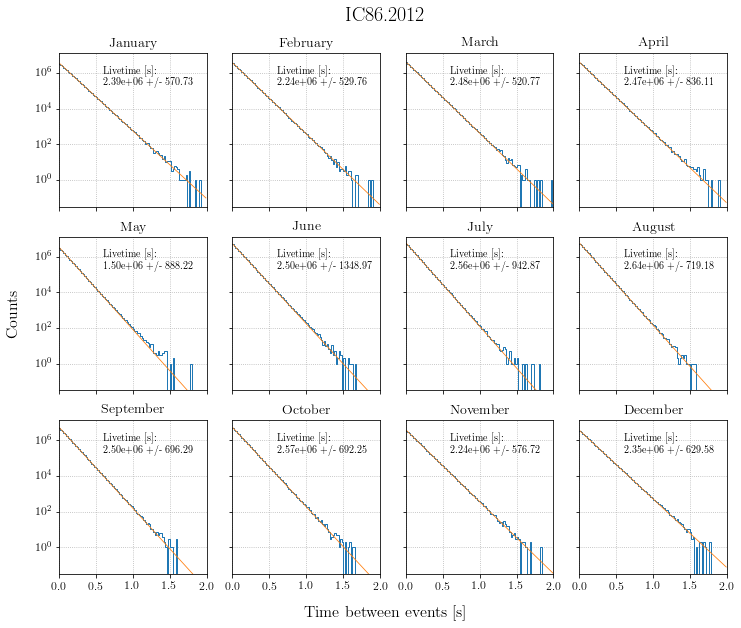

In [8]:
fig, axarr = plt.subplots(3, 4, figsize=(10,8), sharex=True, sharey=True)
for month, ax in zip(df.index, axarr.flatten()):
    row = df.loc[month]
    counts = row['counts']
    I0_fit = row['I0_fit']
    T_fit = row['T_fit']
    livetime = row['livetime']
    livetime_err = row['livetime_err']
    livetime_str = 'Livetime [s]:\n{:0.2e} +/- {:0.2f}'.format(livetime, livetime_err)
    
    # Plot time difference histogram and corresponding fit
    plotting.plot_steps(time_bins, counts, ax=ax)
    ax.plot(time_midpoints, livetime_fit_func(time_midpoints, I0_fit, T_fit),
            marker='None', ls='-', c='C1')
    month_str = datetime.date(2000, month, 1).strftime('%B')
    ax.set_title(month_str)
    ax.set_xlim((0, 2))
    ax.set_yscale('log', nonposy='clip')
    ax.text(0.6, 2e5, livetime_str)
    ax.grid()
    
fig.text(0.5, -0.025, 'Time between events [s]', ha='center', fontsize=16)
fig.text(-0.025, 0.5, 'Counts', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.01, config, ha='center', fontsize=20)
plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/livetime-array-{}.png'.format(config))
plt.show()

In [9]:
full_livetime = df['livetime'].sum()
full_livetime_err = np.sqrt(np.sum([err**2 for err in df['livetime_err']]))
print('Full {} livetime [s]:\n{:0.2e} +/- {:0.2f}'.format(config, full_livetime, full_livetime_err))

Full IC86.2012 livetime [s]:
2.84e+07 +/- 2698.99


In [10]:
data_dict = {'livetime(s)': full_livetime, 'livetime_err(s)': full_livetime_err}
for month in df.index:
    month_str = datetime.date(2000, month, 1).strftime('%B')
    data_dict[month_str + '_livetime(s)'] = df.loc[month]['livetime']
    data_dict[month_str + '_livetime_err(s)'] = df.loc[month]['livetime_err']

livetime_file = comp.get_livetime_file()
try:
    livetime_df = pd.read_csv(livetime_file, index_col=0)
    livetime_df.loc[config] = data_dict
except IOError:
    livetime_df = pd.DataFrame(data_dict, index=[config])
livetime_df.to_csv(livetime_file)

In [11]:
livetime_df

,April_livetime(s),April_livetime_err(s),August_livetime(s),August_livetime_err(s),December_livetime(s),December_livetime_err(s),February_livetime(s),February_livetime_err(s),January_livetime(s),January_livetime_err(s),...,May_livetime(s),May_livetime_err(s),November_livetime(s),November_livetime_err(s),October_livetime(s),October_livetime_err(s),September_livetime(s),September_livetime_err(s),livetime(s),livetime_err(s)
IC86.2012,2.474154e+06,836.110595,2.636265e+06,719.180507,2.352788e+06,629.580407,2.238360e+06,529.76119,2.388066e+06,570.728817,...,1.500543e+06,888.218841,2.242179e+06,576.724,2.570781e+06,692.25032,2.500055e+06,696.293602,2.843990e+07,2698.989669
